# SpectralDefocusCam Iterative Reconstruction Demo

In [1]:
import sys
sys.path.insert(0, "../")

import matplotlib.pyplot as plt
import utils.helper_functions as helper
import utils.diffuser_utils as diffuser_utils
import train
import PIL.Image as Image
import numpy as np, torch
import os, tqdm
import glob

# Change this to GPU or CPU depending on your machine 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = "cuda:1"

%load_ext autoreload
%autoreload 2

if "cuda" in device:
    print(torch.cuda.get_device_name(device))

NVIDIA RTX A6000


### View calibration data and image

In [74]:
psf_path_rel, exposures = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/singlepos/psfs_ONAXIS_telecent25um", [1 / 662, 1 / 110, 1 / 45, 1 / 30, 1 / 21]
#psf_path_rel, exposures = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/03_07/exp_meas/single_pos_ONAXIS_25um", [1/364, 1/120, 1/39, 1/14, 1/4]
#psf_path_rel, exposures = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/03_07/exp_meas/single_pos_ONAXIS_25um_large_aperture", [1/120, 1/25, 1/12, 1/10, 0.437]

#test_meas_path_rel = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/exp_meas/smallduckfront"
#test_meas_path_rel = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/03_07/exp_meas/mushroom_knife"
test_meas_path_rel = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/03_07/exp_meas/usaf_negative"
#test_meas_path_rel = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/03_07/exp_meas/color_palette"

calib_mat_path_rel = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/calib_matrix_2_23_2024_processed/calibration_matrix_L1_390-870_30chan_stride16_avg16.mat"

#exp params
sim_blur = True
w_init = [0.003, 0.018, 0.04, 0.06, 0.095]

crop_center = [1200, 1970]
crop_size = [1260, 1860]
patch_size = [420, 620]

crop_center = [1200, 1970]
crop_size = [768, 768]
patch_size = [256, 256]

ksizes = [7, 21, 45, 55, 65]
num_ims = len(exposures)
threshold = 0.55

stack_depth = 5 # number of images in your stack
blurstride = 1 # stride between ordered blur levels of your measurements
bluridx_offset = 0 # offset of "most in focus" psf

config = {
    "device": device,
    "mask_dir": calib_mat_path_rel,
    "psf_dir": psf_path_rel,
    "data_precomputed": True,
    "forward_model_params": {
        "stack_depth": stack_depth,
        "psf": {
            "lri": False,
            "idx_offset": bluridx_offset,
            "stride": blurstride,
            "symmetric": True,
            "optimize": False,
            "padded_shape": crop_size,
            "exposures": exposures[bluridx_offset:stack_depth*blurstride:blurstride],
            "w_init": w_init,
            "threshold": threshold
        },
        "operations": {
            "sim_blur": False,
            "sim_meas": False,
            "adjoint": False,
            "spectral_pad": False,
            "roll": False
        }
    },
    "recon_model_params": {
        "model_name": "fista",
        "iters": 800,
        "prox_method": 'tv',
        "tau": 0.5,
        "tv_lambda": 1.301,
        "tv_lambdaw": 0.1,
        "tv_lambdax": 0.66,
        "print_every": 20
    },
    "batch_size": 1,
    "patch_size": patch_size,
    "patch_crop": crop_size,
    "image_center": crop_center,
    "loss_function": {
        "name": "mse",
        "params": {
        }
    }
}

model = train.get_model(config, device=device)

Reading psf: 100%|██████████| 5/5 [00:00<00:00, 123.62it/s]


Scaled psfs by values: [1.0, 0.1661631419939577, 0.06797583081570997, 0.045317220543806644, 0.03172205438066465]


Preprocessing: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]

tensor(0.0115, dtype=torch.float64) tensor(0.0454, dtype=torch.float64)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)


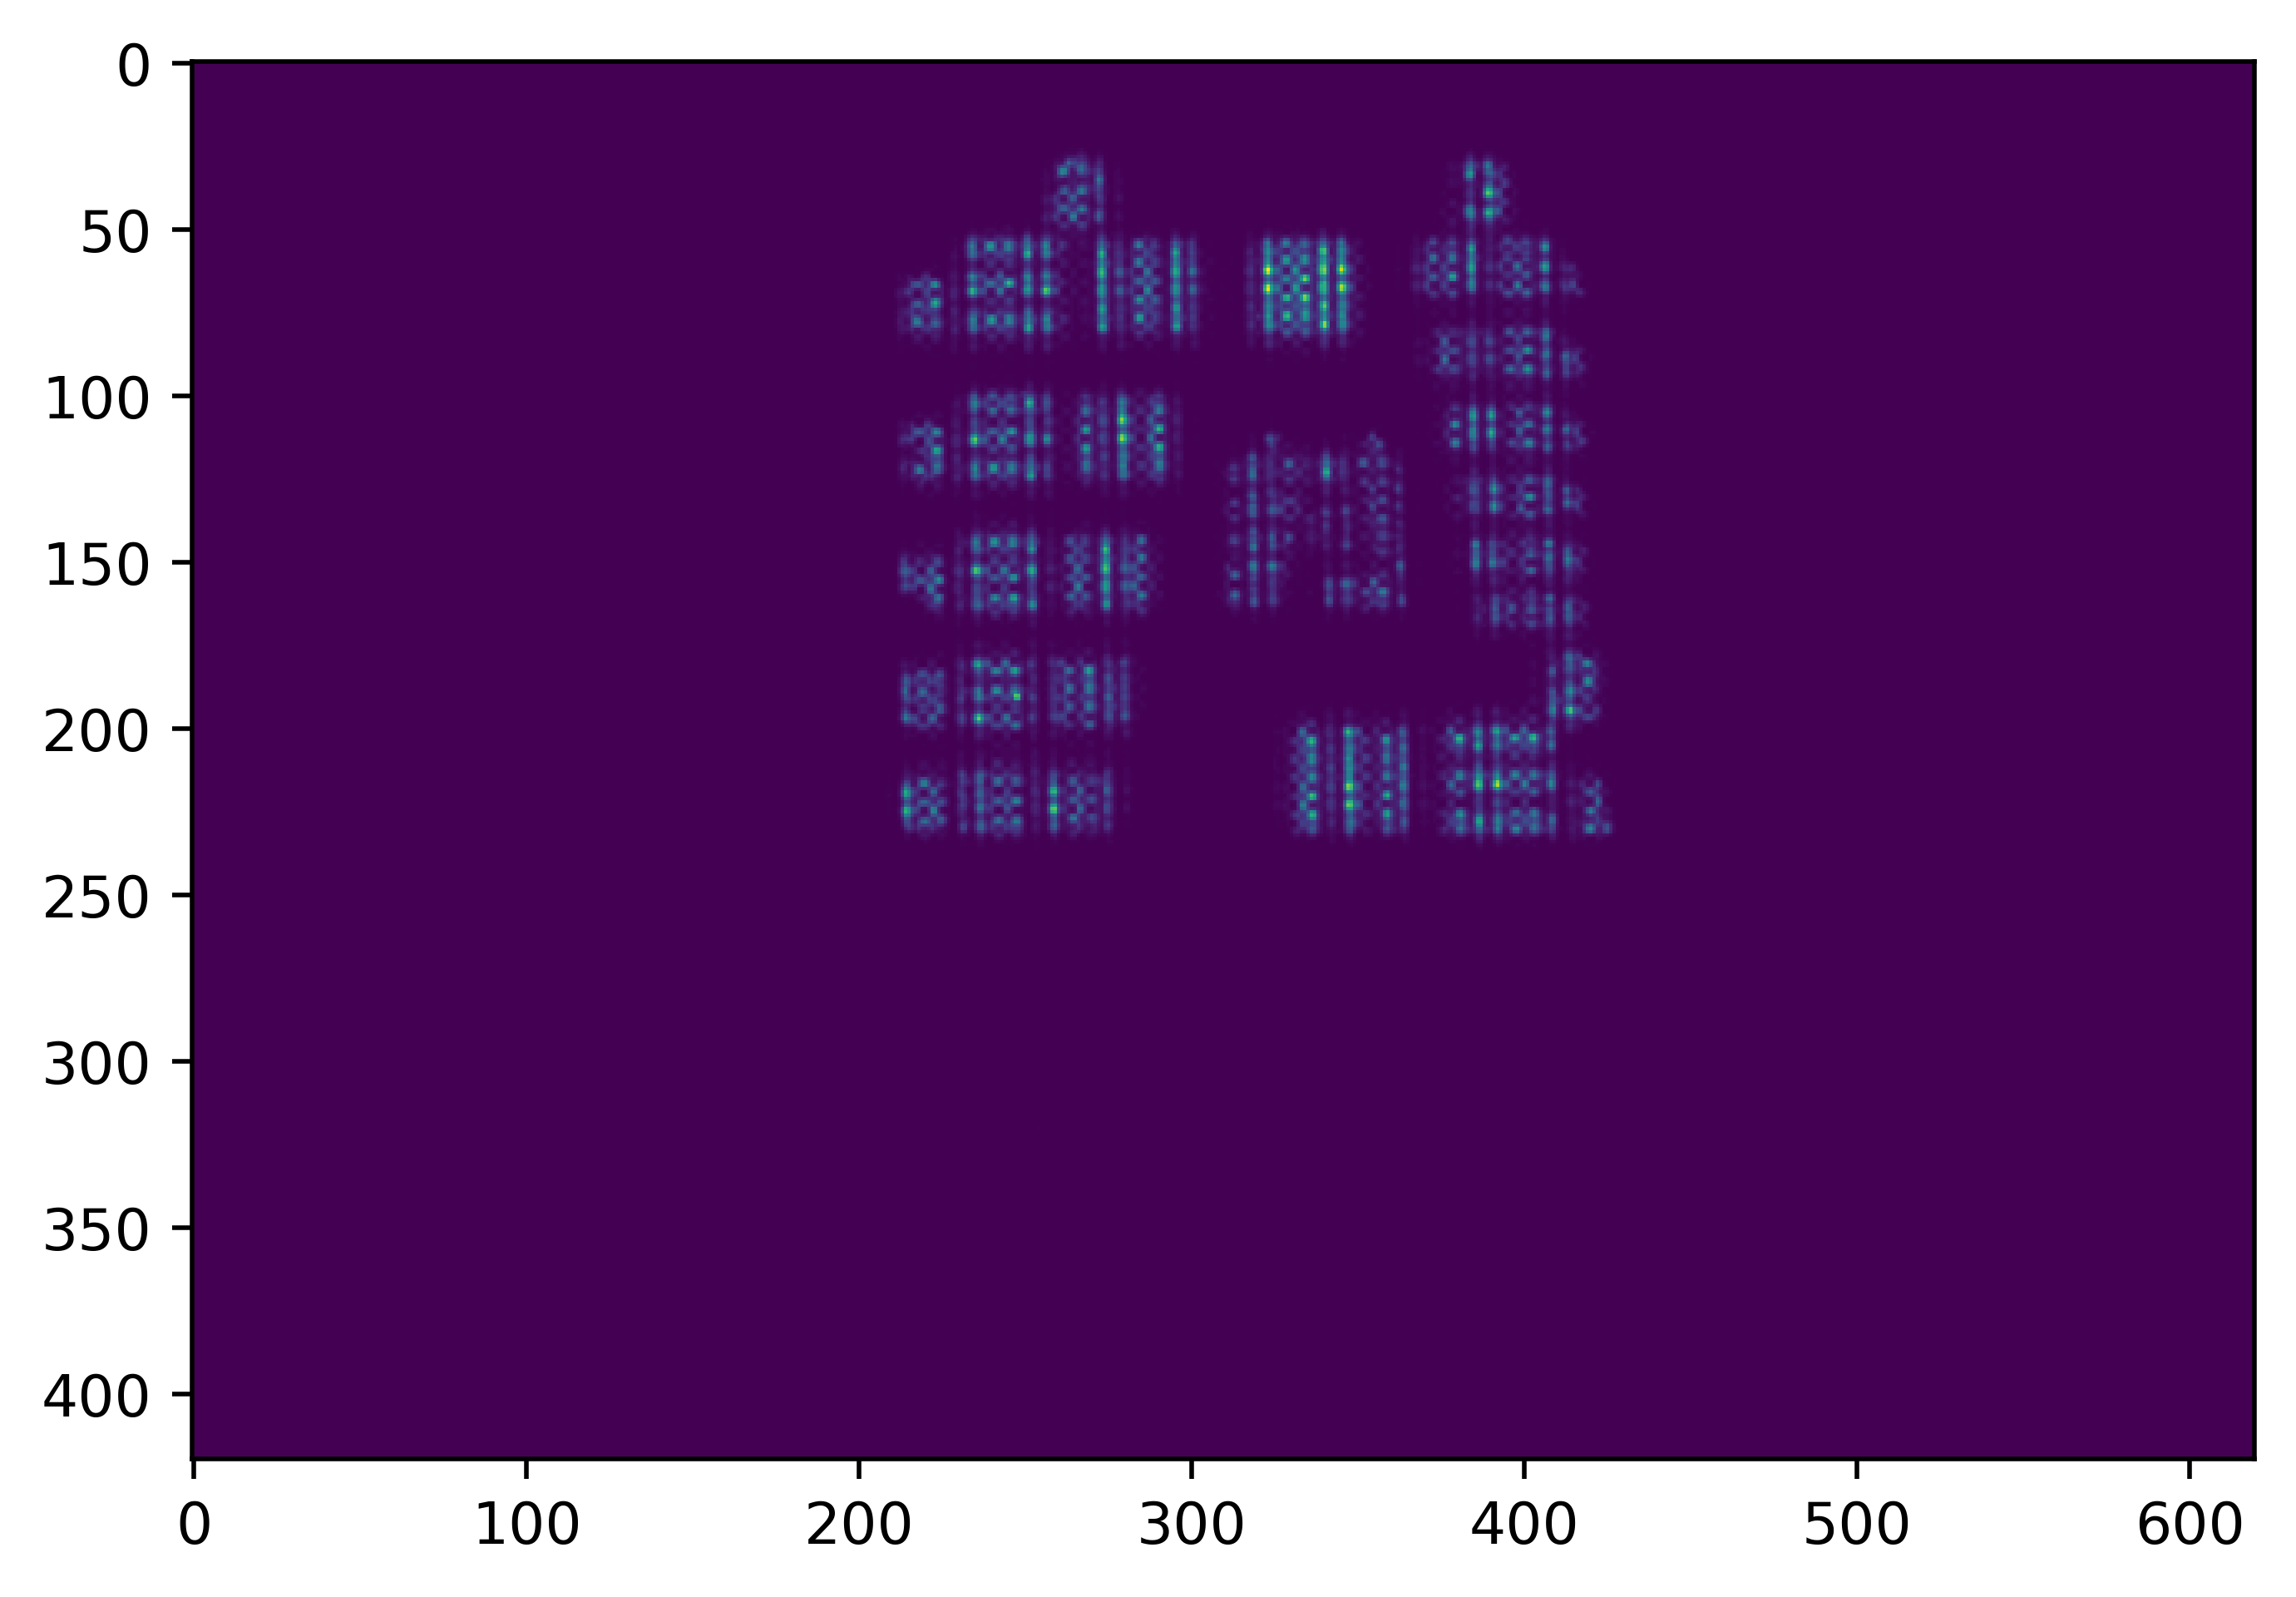

In [55]:
# Experimental measurements
files = sorted(list(glob.glob(os.path.join(test_meas_path_rel, "*.bmp"))) + list(glob.glob(os.path.join(test_meas_path_rel, "*.tiff"))))

prep = lambda x: diffuser_utils.preprocess_meas(
    x, 
    center=crop_center,
    crop_size=crop_size,
    dim=patch_size,
    outlier_std_threshold=5
)
measurements = [prep(np.array(Image.open(x))) for x in tqdm.tqdm(files, "Preprocessing")]
sel_meas_stack = torch.tensor(np.stack(measurements, axis=0))[bluridx_offset:stack_depth*blurstride:blurstride]

print(sel_meas_stack.mean(), sel_meas_stack.std())
print(sel_meas_stack.min(), sel_meas_stack.max())

plt.imshow(sel_meas_stack[0].cpu().numpy())

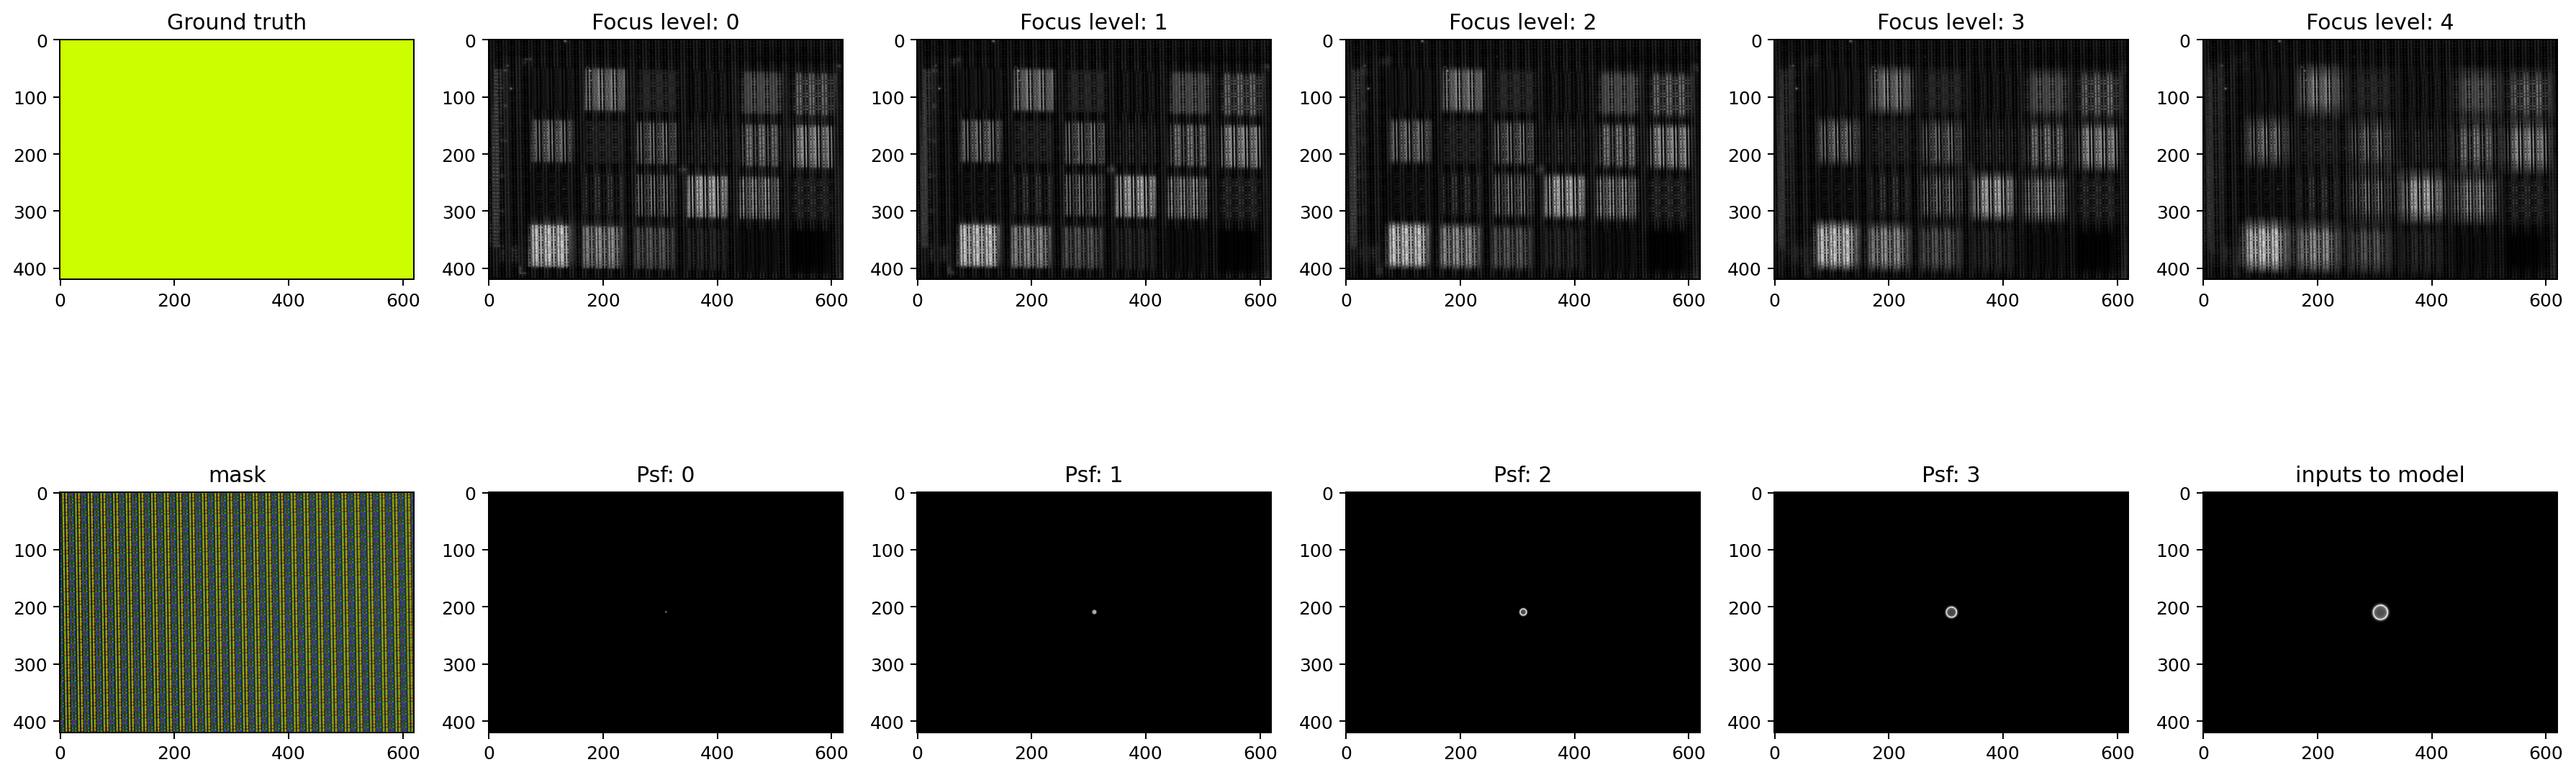

In [27]:
plot = lambda x: helper.value_norm(helper.stack_rgb_opt_30(np.transpose(x, (1,2,0))))
fig, ax = plt.subplots(2, len(sel_meas_stack)+1, figsize = (4*len(sel_meas_stack), 8))
fig.set_dpi(180)
for i in range(len(sel_meas_stack)+1):
    if i == 0:
        ax[0][i].imshow(plot(np.ones((30, patch_size[0], patch_size[1]))))
        ax[0][i].set_title(f"Ground truth")
        ax[1][i].imshow(plot(model.model1.mask[0].cpu().numpy()))
        ax[1][i].set_title(f"mask")
    else:
        ax[0][i].imshow(sel_meas_stack[i-1].cpu().numpy(), cmap='gray')
        ax[0][i].set_title(f"Focus level: {i-1}")
        ax[1][i].imshow(model.model1.psfs[i-1].cpu().numpy(), cmap='gray')
        ax[1][i].set_title(f"Psf: {i-1}")
plt.title("inputs to model")
plt.tight_layout()
plt.show()

## Run model with fista recon

In [21]:
#if using blur only
blur_only = False
if blur_only:
    model.model2.psfs = model.model2.psfs[-1:]
    model.model2.H = model.model2.H[-1:]
    model.model2.Hconj = model.model2.Hconj[-1:]
    sel_meas_stack = sel_meas_stack[-1:]

In [66]:
model.model2.iters = 100
model.model2.tv_lambda = 0.4#0.351 # 0.501 
model.model2.tv_lambdax = 0.66 # 10
model.model2.tv_lambdaw = 1.3
model.model2.print_every = 20
#model.model2.L /= 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  0  loss:  tensor(506.3414, device='cuda:1', dtype=torch.float64)


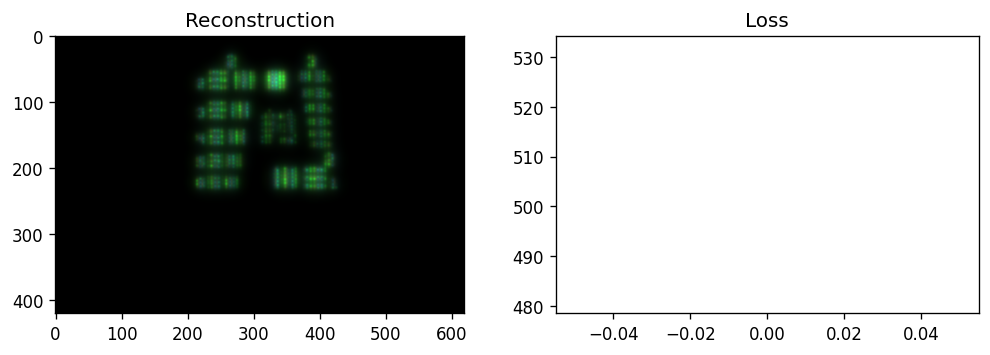

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  20  loss:  tensor(28.8950, device='cuda:1', dtype=torch.float64)


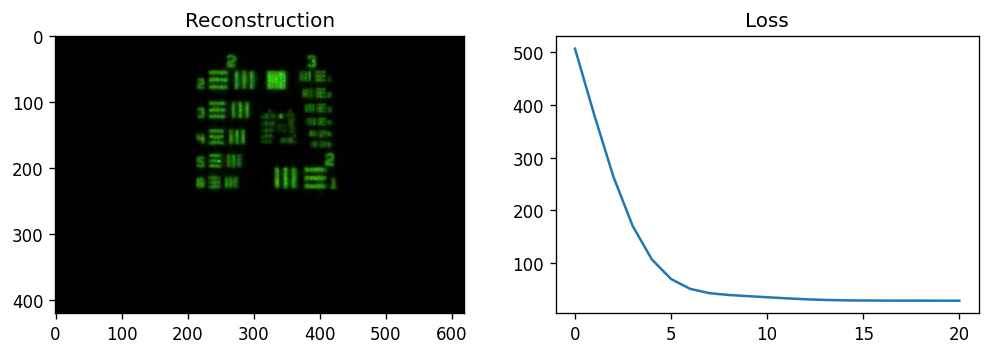

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  40  loss:  tensor(28.0159, device='cuda:1', dtype=torch.float64)


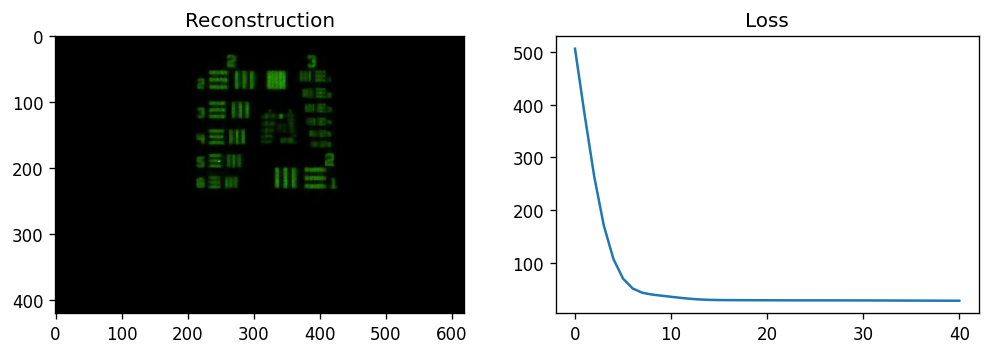

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  60  loss:  tensor(27.9069, device='cuda:1', dtype=torch.float64)


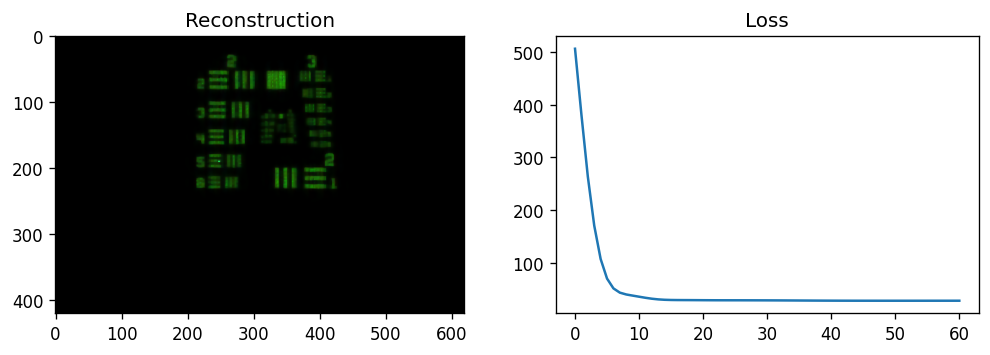

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  80  loss:  tensor(27.9708, device='cuda:1', dtype=torch.float64)


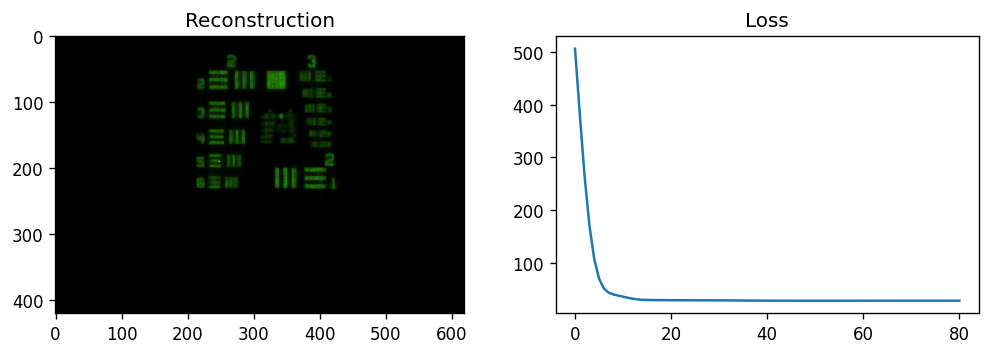

In [67]:
measurement = sel_meas_stack.unsqueeze(0).to(device)
out = model(measurement)

### Visualize Outputs

In [68]:
pred = model.model2.out_img
scaling = (1,1,1)
helper.plot_cube_interactive(helper.value_norm(pred), fc_range=(390, 870), fc_scaling=scaling)

FigureWidget({
    'data': [{'type': 'image',
              'uid': '9857ed32-e18c-468a-8a9a-a9b08e3391c9',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[0, 0, 0],
                           [0, 0, 0],
                           [0, 0, 0],
                           ..., 
                           [0, 0, 0],
                           [0, 0, 0],
                           [0, 0, 0]],
                   
                          [[0, 0, 0],
                           [0, 0, 0],
                           [0, 0, 0],
                           ..., 
                           [0, 0, 0],
                           [0, 0, 0],
                           [0, 0, 0]],
                   
                          [[0, 0, 0],
                           [0, 0, 0],
                           [0, 0, 0],
                           ..., 
                           [0, 0, 0],
                           [0, 0, 0],
                           [0, 0, 0]],
           

In [69]:
im = Image.fromarray((helper.value_norm(helper.select_and_average_bands(helper.value_norm(pred), fc_range=(390,870), scaling=scaling))*255).astype(np.uint8))

np.save(os.path.join("/home/cfoley/defocuscamdata/recons/exp_results_figure/", os.path.basename(test_meas_path_rel) + "_fista_"), pred)
im.save(os.path.join("/home/cfoley/defocuscamdata/recons/exp_results_figure/", os.path.basename(test_meas_path_rel) + "_fista_" f"largecrop_scaling-{scaling}" + ".png"))

In [ ]:
helper.plot_cube_interactive(model.model2.mask.cpu().numpy())

In [ ]:
helper.plot_cube_interactive(model.model2.mask.cpu().numpy())

In [ ]:
savename = f"recons/recon_{os.path.basename(test_meas_path_rel)}{crop_center}_{crop_size}_{model.model2.iters}_{model.model2.tv_lambda}_{model.model2.tv_lambdaw}_{model.model2.tv_lambdax}_{model.model2.psfs.shape[0]}.npy"
with open(savename, "wb") as f:
    np.save(f, recon)